In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
!nvidia-smi

Mon Apr 19 01:26:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.87       Driver Version: 456.87       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8     8W /  N/A |    801MiB /  6144MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from   torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
from RandSamp import getSamples
from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                         FilterBankMotorImagery)
# Extraer los datos
dataset = BNCI2014001()
# Cargar el paradigma a usar
#paradigm = MotorImagery(n_classes=4,
#                    fmin=8,
#                    fmax=35,
#                    tmin=-2,
#                    tmax=5)

In [5]:
#X = np.load("/content/drive/My Drive/data/Graz/X_EEG.npy")
#y = np.load("/content/drive/My Drive/data/Graz/y_EEG.npy")
#metadata = pd.read_csv("/content/drive/My Drive/data/Graz/metadata_EEG.csv")
X = np.load("X_EEG.npy")
y = np.load("y_EEG.npy")
metadata = pd.read_csv("metadata_EEG.csv")
# Load paradigm 
#paradigm = MotorImagery(n_classes=4, fmin=8, fmax=35)

#print(paradigm.__doc__)


#print(paradigm.__doc__)


In [6]:
X2 = X#np.array([[x[:, :1000]] for x in X])
np.shape(X2)

(5184, 22, 1001)

In [12]:
X_train = X2[(metadata["session"]=="session_T")]
y_train = y[(metadata["session"]=="session_T")]

X_test = X2[(metadata["session"]=="session_E")]
y_test = y[(metadata["session"]=="session_E")]

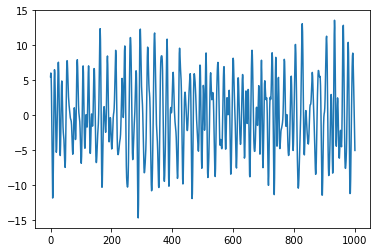

In [13]:
plt.plot(X_train[0, 0])

In [14]:
mxx = np.max(X_train) / 4
X_train = (X_train / mxx)
X_test = (X_test / mxx)

X_train = torch.from_numpy(X_train).float().cuda()
X_test = torch.from_numpy(X_test).float().cuda()

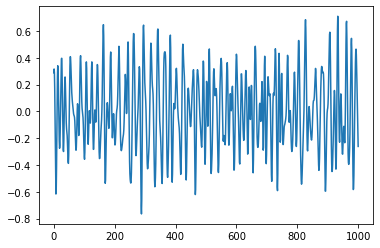

In [15]:
plt.plot(X_train[0, 0,].cpu().numpy())

In [19]:
trainloader = DataLoader(X_train, batch_size=128, shuffle=True)
testloader = DataLoader(X_test, batch_size=128, shuffle=True)

In [421]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        #### Encoder
        self.conv1 = nn.Sequential(
            nn.Conv1d(22, 32, 3), 
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, 3),  
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, 3),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, 3),
            nn.ELU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(2),  
        )

        
        
        ### Decoder 
        self.convt1 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(128),
        )
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(64),
        )
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(32),
        )
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose1d(32, 22, 3, 2), 
            #nn.Tanh()
        )
        
        self.encoder = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
        )
        
        self.decoder = nn.Sequential(
            self.convt1,
            self.convt2,
            self.convt3,
            self.convt4,
        )

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    

    

In [489]:
torch.cuda.empty_cache()
learning_rate = 0.001
autoencoder = Autoencoder().cuda()

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [560]:
Cost = []
#encoder.train()
#decoder.train()

autoencoder.train()
for epoch in range(20):
    runnning_loss = 0
    for data in trainloader:

        # ===================forward=====================
        #encoded = encoder(data)
        output = autoencoder(data)[:, :22, 1:1001]
        loss = criterion(output, data[:, :22, :1000])
        Cost.append(loss.item())
        runnning_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoca: ", epoch, " loss: ", runnning_loss)


Epoca:  0  loss:  0.07694976055063307
Epoca:  1  loss:  0.08126367116346955
Epoca:  2  loss:  0.07945247599855065
Epoca:  3  loss:  0.08077849633991718
Epoca:  4  loss:  0.08047416480258107
Epoca:  5  loss:  0.07968100369907916
Epoca:  6  loss:  0.07773490063846111
Epoca:  7  loss:  0.0770721547305584
Epoca:  8  loss:  0.07605073554441333
Epoca:  9  loss:  0.0741308678407222
Epoca:  10  loss:  0.0792047290597111
Epoca:  11  loss:  0.07825563102960587
Epoca:  12  loss:  0.0751228432636708
Epoca:  13  loss:  0.07448983006179333
Epoca:  14  loss:  0.07620701286941767
Epoca:  15  loss:  0.07474585296586156
Epoca:  16  loss:  0.0743197719566524
Epoca:  17  loss:  0.07905131112784147
Epoca:  18  loss:  0.07763610244728625
Epoca:  19  loss:  0.07703251228667796


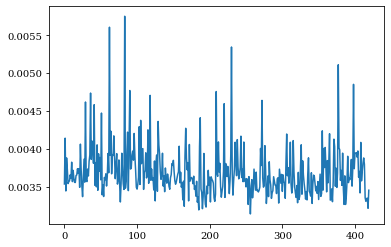

In [561]:
#with torch.no_grad():
#    out = model.encoder(data)
plt.plot(Cost)

In [562]:
with torch.no_grad():
    out = autoencoder.conv1(data)
    out = autoencoder.conv2(out)
    out = autoencoder.conv3(out)
    out = autoencoder.conv4(out)
    #out = autoencoder.convt1(out)
    #out = autoencoder.convt2(out)
    #out = autoencoder.convt3(out)

out.shape

torch.Size([32, 256, 60])

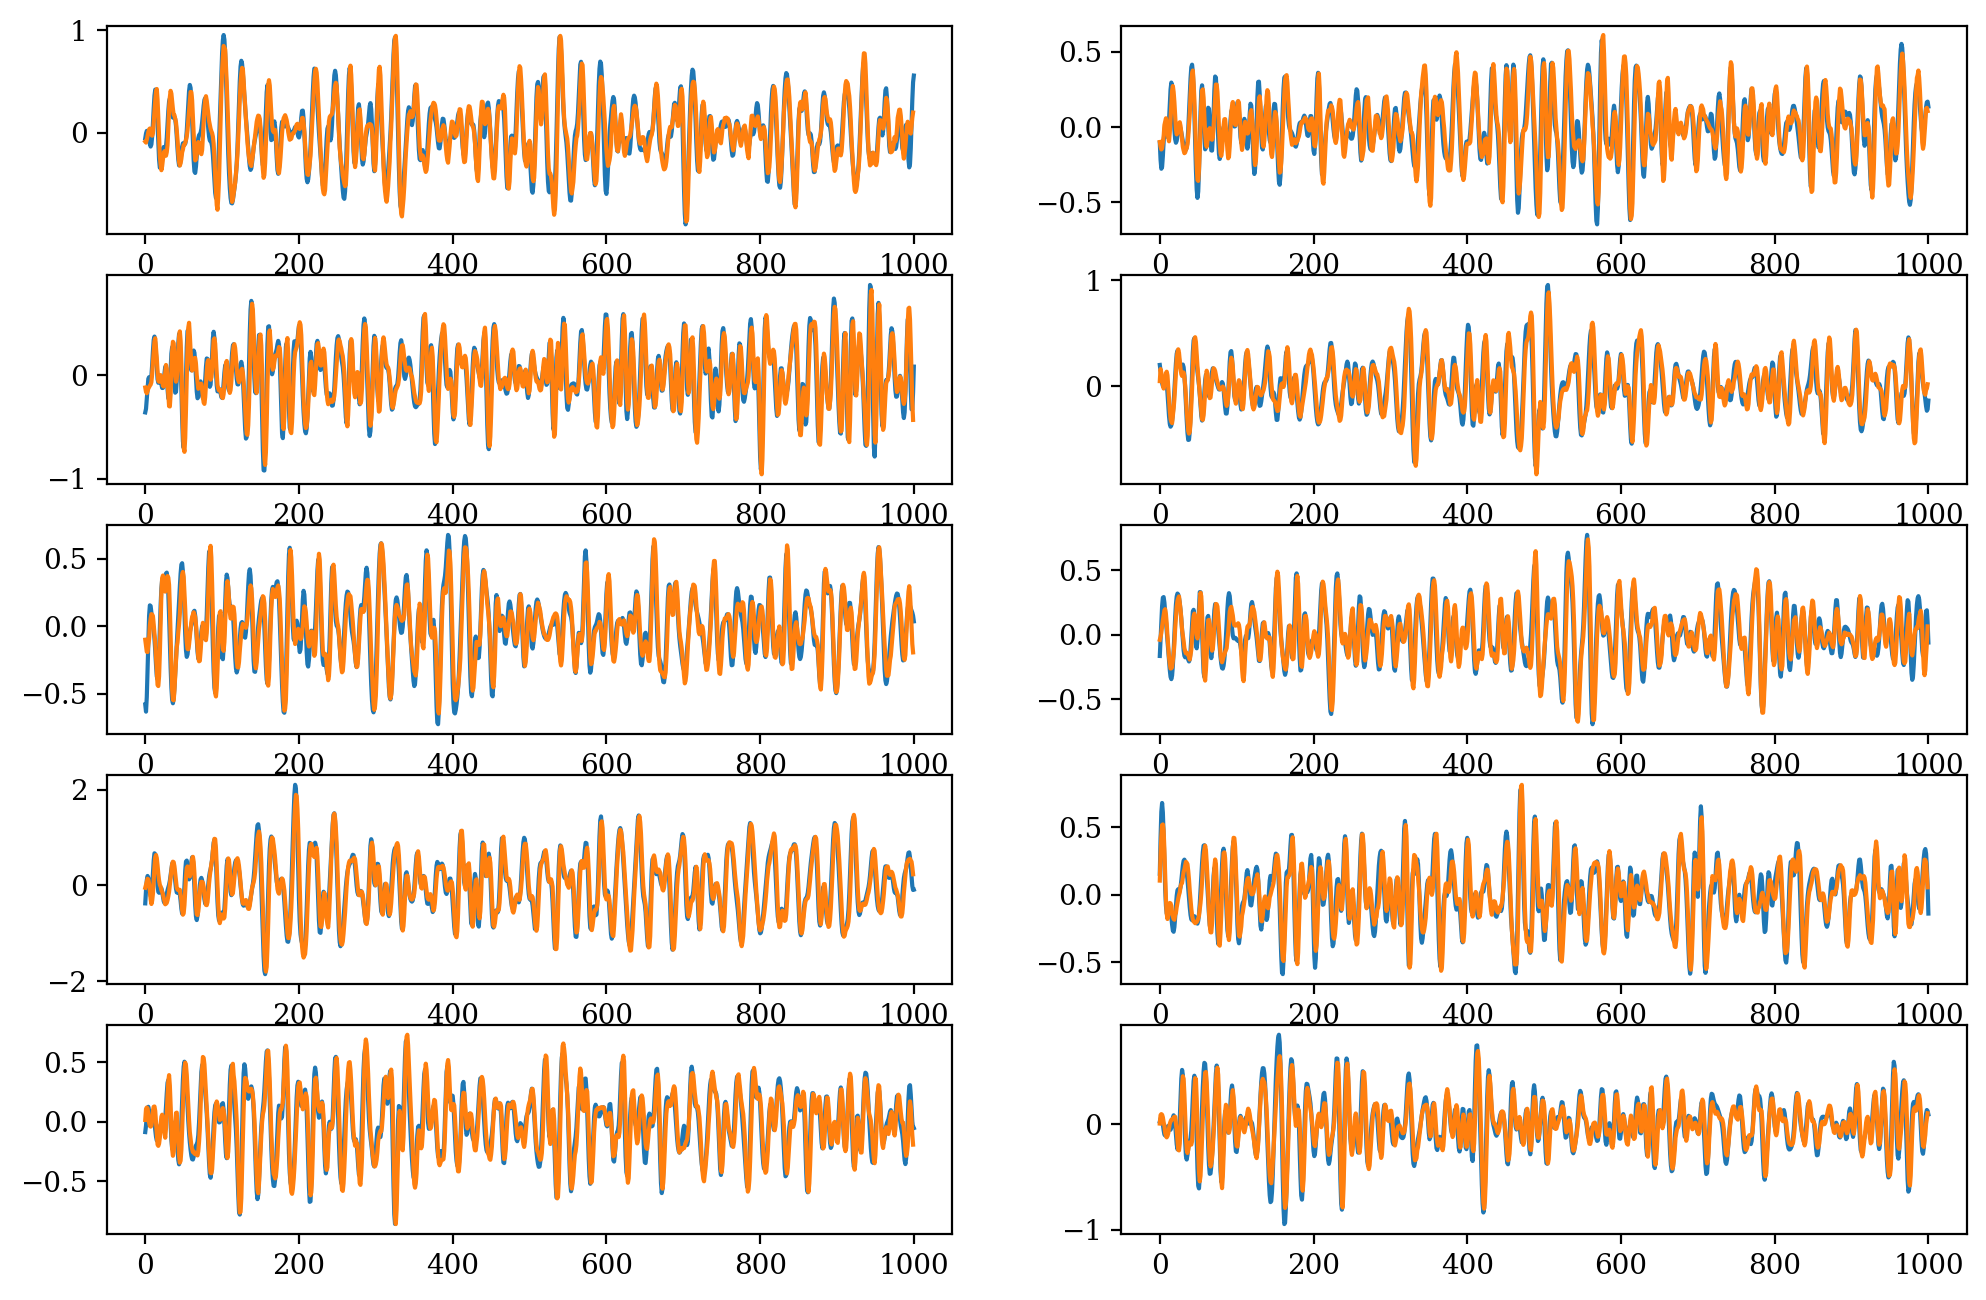

In [563]:
#encoder.eval()
#decoder.eval()
autoencoder.eval()
with torch.no_grad():
    output = autoencoder(data)[:, :22, :1000]

plt.figure(figsize=(12, 8), dpi=200)
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(data[i,0].cpu().numpy())
    plt.plot(output[i,0].cpu().numpy())

In [564]:
output.max()

tensor(2.4053, device='cuda:0')

In [565]:
from matplotlib.colors import ListedColormap
# Define colores
esmeralda = "#2ecc71"
belize = "#2980b9"
pome = "#c0392b"
ameth = "#9b59b6"
sun = "#f1c40f"
pumpkin = "#d35400"

palette = ListedColormap([esmeralda, belize, pome, ameth])
# Configuración de matplotlib
#plt.rcParams["font.family"] = "Palatino Linotype"
plt.rcParams["font.size"] = 10
plt.rcParams["font.weight"] = "regular"
plt.rcParams['font.family'] = 'serif'

#pal = sns.color_palette([esmeralda, belize, pome, ameth])

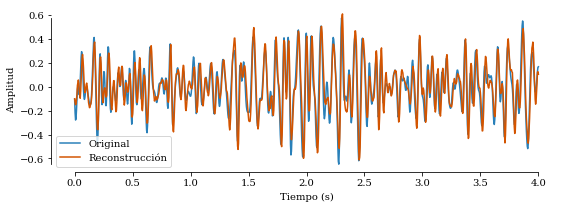

In [566]:
tiempo = np.linspace(0, 4, len(output[1,0].cpu()))
fig, ax = plt.subplots(figsize=(8,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(min(data[1,0].cpu().numpy()), max(data[1,0].cpu().numpy()))

ax.plot(tiempo, data[1,0].cpu().numpy()[:1000],
 color=belize,
 label="Original")
ax.plot(tiempo, output[1,0].cpu().numpy(),
color=pumpkin,
 label="Reconstrucción")

plt.legend()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
#plt.savefig("figures/recon3.pdf")

In [567]:
autoencoder.eval()
## Error en el set de entrenamiento
with torch.no_grad():
    running_error = 0
    for data in trainloader:
        out = autoencoder(data)[:, :22, 1:1001]
        running_error += (data[:, :22, :1000]*mxx-out*mxx).pow(2).mean().item()

In [568]:
np.sqrt(running_error)

5.350800430724646

In [569]:
with torch.no_grad():
    running_error = 0
    for data in testloader:
        out = autoencoder(data)[:, :22, 1:1001]
        running_error += (data[:, :22, :1000]*mxx-out*mxx).pow(2).mean().item()

In [570]:
np.sqrt(running_error)

5.947402787153686

In [160]:
autoencoder

Autoencoder(
  (conv1): Sequential(
    (0): Conv1d(22, 32, kernel_size=(16,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(12,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(12,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(12,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(256, eps=1e-05, mom

In [55]:
torch.save(autoencoder.state_dict(), "autoencoder1D.pt")

In [15]:
torch.onnx.export(autoencoder, data, "autoenonxx.onnx")